
## IMDb



figure out how to save model. 
upload data from deloitte,  process test data in same way as other data. 
get a good pred, upload

data in. rationalize data structure. had mismatch with max 1000

At Fast.ai we have introduced a new module called fastai.text which replaces the torchtext library that was used in our 2018 dl1 course. The fastai.text module also supersedes the fastai.nlp library but retains many of the key functions.

In [1]:
#!pip install git+https://github.com/fastai/fastai.git # grabbing latest version
#!pip install spacy
#!python -m spacy download en

In [2]:
from fastai.text import *
import html

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: nump

The Fastai.text module introduces several custom tokens.

We need to download the IMDB large movie reviews from this site: http://ai.stanford.edu/~amaas/data/sentiment/
Direct link : [Link](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and untar it into the PATH location. We use pathlib which makes directory traveral a breeze.

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('imdb_data/aclImdb/')

In [4]:
#!mkdir "imdb_data"

## Standardize format

In [5]:
CLAS_PATH=Path('imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

The imdb dataset has 3 classes. positive, negative and unsupervised(sentiment is unknown). 
There are 75k training reviews(12.5k pos, 12.5k neg, 50k unsup)
There are 25k validation reviews(12.5k pos, 12.5k neg & no unsup)

Refer to the README file in the imdb corpus for further information about the dataset.

In [5]:
col_names = ['labels','text']

In [6]:

# Grabbing D data
#!git clone https://github.com/rgilman33/imdb_sync.git

In [7]:
# Reading in the train set and the test set. Creating single df w everthing.

df_trn = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_trn["dataset"] = "train"; df_test["dataset"] = "test"
df_test["labels"] = 3

df = pd.concat([df_trn, df_test], axis=0); print(len(df))
df.head()

50000


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,dataset,id,labels,text
0,train,2592,0,Un-bleeping-believable! Meg Ryan doesn't even ...
1,train,18359,1,This is a extremely well-made film. The acting...
2,train,1040,0,Every once in a long while a movie will come a...
3,train,17262,1,Name just says it all. I watched this movie wi...
4,train,9908,0,This movie succeeds at being one of the most u...


In [8]:
df_trn.text.str.len().mean(), df_test.text.str.len().mean()

(1325.31292, 1294.0274)

In [16]:
# Saving to csv to open again with chunks

df.to_csv(LM_PATH/'df.csv', index=False)

## Language model tokens

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

In [17]:
chunksize= 10000

In [18]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [19]:
def get_texts(df, n_lbls=1):
    texts = f'\n{BOS} {FLD} 1 '
    texts += df["text"].astype(str) # wow, think i was sending in real labels as part of text...
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

In [20]:
def get_all(df, n_lbls):
    tok = []
    for i, r in enumerate(df):
        print(i)
        tok_ = get_texts(r, n_lbls)
        tok += tok_;
    return tok

In [21]:
# Reading back in with chunks

df_chunks = pd.read_csv(LM_PATH/'df.csv', chunksize=chunksize)

In [22]:
# getting list of tokenized lists

tok_text = get_all(df_chunks, 1)
len(tok_text)

0


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


1
2
3
4


50000

In [23]:
# adding back to df
df["tokenized_text"] = tok_text

In [24]:
df.head()

,dataset,id,labels,text,tokenized_text
0,train,2592,0,Un-bleeping-believable! Meg Ryan doesn't even ...,"[\n, xbos, xfld, 1, un, -, bleeping, -, believ..."
1,train,18359,1,This is a extremely well-made film. The acting...,"[\n, xbos, xfld, 1, this, is, a, extremely, we..."
2,train,1040,0,Every once in a long while a movie will come a...,"[\n, xbos, xfld, 1, every, once, in, a, long, ..."
3,train,17262,1,Name just says it all. I watched this movie wi...,"[\n, xbos, xfld, 1, name, just, says, it, all,..."
4,train,9908,0,This movie succeeds at being one of the most u...,"[\n, xbos, xfld, 1, this, movie, succeeds, at,..."


create symlink to spacy en model

mklink C:\Users\rudyg\AppData\Local\conda\conda\envs\fastai\lib\site-packages\spacy\data\en C:\Users\rudyg\AppData\Local\conda\conda\envs\fastai\lib\site-packages\en_core_web_sm

In [25]:
freq = Counter(p for o in df.tokenized_text for p in o)
freq.most_common(25)

[('the', 666238),
 ('.', 549276),
 (',', 542898),
 ('and', 323667),
 ('a', 321663),
 ('of', 289313),
 ('to', 267950),
 ('is', 217126),
 ('it', 189546),
 ('in', 186509),
 ('i', 173646),
 ('this', 150480),
 ('that', 144270),
 ('"', 130201),
 ("'s", 121976),
 ('-', 103672),
 ('was', 100025),
 ('\n\n', 98729),
 ('as', 91576),
 ('movie', 87553),
 ('for', 87334),
 ('with', 87262),
 ('but', 83204),
 ('film', 79428),
 ('you', 68831)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [26]:
max_vocab = 60000
min_freq = 2

In [27]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [28]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(stoi)

52234

In [29]:
stoi["the"], stoi["awesome"]

(2, 1181)

In [30]:
numerized_tokens = [[stoi[o] for o in p] for p in df.tokenized_text]

In [31]:
len(numerized_tokens), len(numerized_tokens[0])

(50000, 91)

In [32]:
df["numerized_tokens"] = numerized_tokens

In [33]:
df["numerized_tokens"].iloc[0][:20]

[40,
 41,
 42,
 37,
 2773,
 17,
 36931,
 17,
 839,
 47,
 4951,
 1666,
 90,
 29,
 76,
 182,
 57,
 678,
 20287,
 3089]

In [34]:
vs=len(itos); vs

52234

In [35]:
df.to_csv("prepped_data.csv", index=False)

In [6]:
# Grabbing prepped data

df = pd.read_csv("prepped_data.csv"); print(len(df))
vs = 52234 # manually set this to match above

import ast
df["numerized_tokens"] = df["numerized_tokens"].apply(lambda x: ast.literal_eval(x))

50000


In [7]:
df.head()

,dataset,id,labels,text,tokenized_text,numerized_tokens
0,train,2592,0,Un-bleeping-believable! Meg Ryan doesn't even ...,"['\n', 'xbos', 'xfld', '1', 'un', '-', 'bleepi...","[40, 41, 42, 37, 2773, 17, 36931, 17, 839, 47,..."
1,train,18359,1,This is a extremely well-made film. The acting...,"['\n', 'xbos', 'xfld', '1', 'this', 'is', 'a',...","[40, 41, 42, 37, 13, 9, 6, 583, 89, 17, 110, 2..."
2,train,1040,0,Every once in a long while a movie will come a...,"['\n', 'xbos', 'xfld', '1', 'every', 'once', '...","[40, 41, 42, 37, 189, 303, 11, 6, 217, 156, 6,..."
3,train,17262,1,Name just says it all. I watched this movie wi...,"['\n', 'xbos', 'xfld', '1', 'name', 'just', 's...","[40, 41, 42, 37, 410, 55, 563, 10, 43, 3, 12, ..."
4,train,9908,0,This movie succeeds at being one of the most u...,"['\n', 'xbos', 'xfld', '1', 'this', 'movie', '...","[40, 41, 42, 37, 13, 21, 2814, 44, 129, 38, 7,..."


In [8]:
df[df.dataset=="test"].head()

,dataset,id,labels,text,tokenized_text,numerized_tokens
25000,test,98481,3,Bud Abbott and Lou Costello always had a good ...,"['\n', 'xbos', 'xfld', '1', 'bud', 'abbott', '...","[40, 41, 42, 37, 5284, 7045, 5, 3741, 6007, 23..."
25001,test,88606,3,"This film is not your typical Hollywood fare, ...","['\n', 'xbos', 'xfld', '1', 'this', 'film', 'i...","[40, 41, 42, 37, 13, 25, 9, 32, 145, 798, 366,..."
25002,test,88639,3,"Henry Thomas, and Robin Tunny, are a couple of...","['\n', 'xbos', 'xfld', '1', 'henry', 'thomas',...","[40, 41, 42, 37, 1635, 1660, 4, 5, 1886, 34013..."
25003,test,76170,3,This digital horror film brings us into the Mi...,"['\n', 'xbos', 'xfld', '1', 'this', 'digital',...","[40, 41, 42, 37, 13, 3654, 206, 25, 993, 199, ..."
25004,test,81803,3,I just saw this on a local independent station...,"['\n', 'xbos', 'xfld', '1', 'i', 'just', 'saw'...","[40, 41, 42, 37, 12, 55, 232, 13, 28, 6, 714, ..."


## wikitext103 conversion

We are now going to build an english language model for the IMDB corpus. We could start from scratch and try to learn the structure of the english language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the IMDB LM. 

In [36]:
#! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2018-08-23 20:33:47--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘imdb_data/aclImdb/models/wt103/index.html’

models/wt103/index. 100%[===================>]     857  --.-KB/s    in 0s      

2018-08-23 20:33:47 (150 MB/s) - ‘imdb_data/aclImdb/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-08-23 20:33:47--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-08-23 20:33:47 ERROR 404: Not Found.

--2018-08-23 20:33:47--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘imdb_data/aclImdb/models/wt103/index.html?C=N;O=D’

models/w

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

In [7]:
em_sz,nh,nl = 400,1150,3

In [39]:
# Grabbing the files from the download 

PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [40]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [41]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [42]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [43]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
counter = 0
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m
    if r<0:counter += 1

In [44]:
len(itos), counter

(52234, 6629)

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [45]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new IMDB language pytorch model!

## Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the IMDB LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [8]:
wd=1e-7
bptt= 70
bs= 52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [47]:
# getting train and test

trn_lm, val_lm = sklearn.model_selection.train_test_split(np.array(df["numerized_tokens"]), test_size=0.1)
len(trn_lm), len(val_lm)

(45000, 5000)

In [48]:
trn_lm[:10]

array([list([40, 41, 42, 37, 812, 11885, 4, 46, 922, 7, 3141, 11, 2263, 17, 226, 5, 110, 17, 22, 17, 257, 125, 4, 427, 239, 48, 11479, 319, 11957, 7, 97, 847, 17, 644, 51, 5342, 20490, 49, 232, 728, 249, 7, 2, 25, 4, 283, 1202, 17, 26503, 104, 10, 325, 17, 115, 161, 3, 89, 4, 12, 158, 55, 359, 43, 2, 99, 890, 847, 22, 13, 25, 5, 254, 6634, 8, 82, 32, 6, 700, 97, 675, 324, 59, 2, 11802, 3855, 17, 14, 155, 39, 216, 8, 36, 26, 13097, 58, 8, 796, 13, 25, 47, 47, 19, 812, 11885, 1285, 48, 7736, 22, 35, 237, 11, 13, 25, 5, 167, 10, 76, 303, 101, 137, 26, 153, 34, 1824, 10, 50, 93, 201, 220, 3, 19, 277, 8, 39, 5095, 4, 12, 3162, 8, 16308, 13, 25, 3, 323, 4, 12, 275, 555, 6979, 196, 189, 38, 7, 75, 638, 14131, 17, 2986, 3, 13, 9, 63, 311, 4, 809, 25, 17, 252, 9, 59, 3, 13, 9, 32, 145, 798, 366, 16547, 4, 136, 287, 9, 10811, 17, 10, 16, 50, 809, 5, 311, 8, 134, 14, 100, 36, 213, 10, 16, 463, 28, 6, 163, 1555, 47, 47]),
       list([40, 41, 42, 37, 31, 1341, 4, 438, 1252, 3742, 62, 3709, 51, 2, 

In [49]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [50]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7 # We should probably update these to match below? Or tune mult upwards

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [51]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1) # why are we unfreezing this one? Don't we want to unfreeze FIRST layer?
#learner.freeze_all_but(0) # unfreezing embedding instead

In [52]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [53]:
lr=1e-3
lrs = lr

In [54]:
# Train for one epoch, just the embedding layer

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.702822   4.489972   0.253783  



[array([4.48997]), 0.25378331182331876]

In [55]:
learner.save('lm_last_ft')

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [55]:
learner.load('lm_last_ft')

In [56]:
learner.unfreeze()

In [77]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      5.318755   5.140305   0.217942  



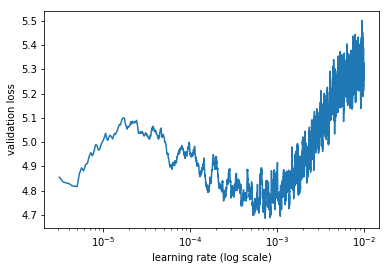

In [78]:
learner.sched.plot()

In [57]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=4) #JH did 15 here. Trying 10. RESULT: 4 is ideal. 8.26 doing 4 

epoch      trn_loss   val_loss   accuracy                     
    0      4.369006   4.184027   0.283078  
    1      4.188926   4.097981   0.29145                      
    2      4.111346   4.056015   0.295844                     
    3      4.038394   4.035749   0.298004                     



[array([4.03575]), 0.2980042148173962]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [60]:
learner.save('lm1')

In [61]:
learner.save_encoder('lm1_enc') # We've got a good one saved. 8.24

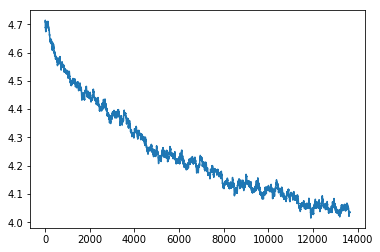

In [62]:
learner.sched.plot_loss()


In [63]:
for c in learner.children:
    for p in c.parameters():
        del p
    del c
        
del learner
        
torch.cuda.empty_cache()



## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.

In [9]:
# Only using data with labels
no_test_df = df[df["dataset"]=="train"] #.drop_duplicates(subset="text") actually can't do this w out changing vocab

# Splitting that subset into train and val
trn_df, val_df = sklearn.model_selection.train_test_split(no_test_df, test_size=0.1)

len(no_test_df), len(df), len(trn_df), len(val_df)

(25000, 50000, 22500, 2500)

In [10]:
# Actual Test

test_df = df[df["dataset"]=="test"]; test_df.shape

(25000, 6)

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [11]:
trn_clas = np.array(trn_df["numerized_tokens"])
val_clas = np.array(val_df["numerized_tokens"])
test_clas = np.array(test_df["numerized_tokens"])

trn_labels = np.squeeze(np.array(trn_df["labels"]))
val_labels = np.squeeze(np.array(val_df["labels"]))
test_labels = np.squeeze(np.array(test_df["labels"])) # placeholder. meaningless

trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
test_ds = TextDataset(test_clas, test_labels)


In [12]:
trn_clas[:1], test_clas[:1]

(array([list([40, 41, 42, 37, 2, 21, 178, 62, 6, 999, 66, 81, 4, 24, 239, 14485, 196, 11, 464, 1371, 1378, 3, 10, 16, 238, 20, 61, 2, 170, 3538, 2, 21, 316, 230, 660, 2, 74, 8, 114, 65, 3309, 1932, 11, 2, 25, 3, 2397, 4923, 90, 6, 999, 556, 315, 11, 35, 237, 91, 24, 157, 9, 715, 1026, 51, 464, 1371, 154, 3, 19, 13, 15338, 553, 21, 95, 36, 98, 4115, 8, 59, 6, 267, 553, 21, 3, 5, 258, 71, 36, 98, 6, 93, 146, 25, 84, 10, 32, 84, 2, 250, 20, 61, 10, 18, 1349, 316, 3, 19])],
       dtype=object),
 array([list([40, 41, 42, 37, 5284, 7045, 5, 3741, 6007, 234, 84, 6, 66, 982, 786, 433, 4, 24, 11, 83, 3887, 12, 121, 26, 95, 151, 14, 45, 79, 110, 38, 25, 14, 95, 39, 22238, 22, 370, 3, 682, 5, 2, 19165, 18, 14, 38, 25, 3, 19, 10, 18, 191, 7, 6, 126, 456, 1719, 803, 51, 2828, 1134, 4, 2, 357, 25, 129, 7045, 5, 6007, 917, 1565, 23246, 3, 152, 85, 2, 79, 126, 125, 2, 877, 110, 11, 1459, 3, 19, 2, 126, 7, 113, 4, 58, 7, 176, 20, 678, 4, 211, 6, 315, 22, 6, 69, 12751, 5, 2902, 210, 611, 39931, 20, 6, 

In [13]:
bs = 40 # reducing this bs bc got mem error

In [14]:
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
#test_samp = SortSampler(test_clas, key=lambda x: len(test_clas[x]))

trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=1) # for ease of submission, don't sort out of order

md = ModelData(PATH, trn_dl, val_dl)

In [15]:
# This is from imdb script. USING THESE.

dropmult = 1.0
dps = np.array([0.4,0.5,0.05,0.3,0.4])*dropmult

lrm = 2.6
lr=0.01
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

wd = 1e-6

In [16]:
# These are taken from arxiv paper JH.

lrs = [0.0001, 0.0001, 0.0001, 0.0001, .001]

In [17]:
c = 2 # NUMBER OF CLASSES


m = get_rnn_classifier(bptt, 20*bptt, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

# Was getting error here in normal pip installed version. Have to get latest from github, then pip install as above

In [18]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) # changing down to 70

In [19]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [76]:
learn.load_encoder('lm1_enc')

In [77]:
learn.freeze_to(-1)

In [43]:
#learn.lr_find(lrs/1000)
#learn.sched.plot()

In [78]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.35873    0.247925   0.9008    



[array([0.24793]), 0.9007999992370606]

In [79]:
learn.save('clas_0')

In [42]:
learn.load("clas_0")

In [80]:
learn.freeze_to(-2)

In [81]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.358904   0.236666   0.9084    



[array([0.23667]), 0.9083999972343445]

In [82]:
learn.save('clas_1')

In [25]:
learn.load('clas_1')

In [23]:
learn.unfreeze()

In [37]:
learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr=(32,10)) 
# JH uses 14. 8.26: first 4, then 3, then 2. saved model, reloaded 8.27 and set up for 5 epochs. pred on this, now 20 more

  0%|          | 3/1125 [00:08<50:40,  2.71s/it, loss=0.211]  

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

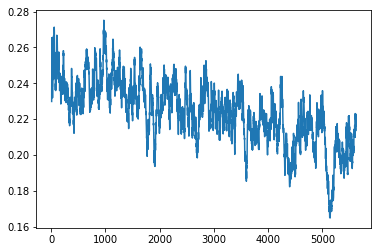

In [25]:
learn.sched.plot_loss() # Loss is still going down. We could keep training this guy if necessary

In [26]:
learn.save('clas_2')

In [20]:
learn.load('clas_2')

## using different pred apparatus

In [23]:
model = learn.model
model.reset()
model.eval()

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(52315, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(52315, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.4)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=50, out_features=2, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm1

In [45]:
model.reset()
model.eval()

probs = []
LEN = 100#len(test_clas)

for i in range(LEN):
    test_txt = test_clas[i+600]; #print(test_df.text.iloc[i])

    ary = np.reshape(np.array(test_txt),(-1,1))

    # turn this array into a tensor
    tensor = torch.LongTensor(ary)

    # wrap in a torch Variable
    variable = Variable(tensor).cuda()

    # do the predictions
    predictions = model(variable)

    # convert back to numpy
    numpy_preds = predictions[0].data.cpu().numpy()

    prob = softmax(numpy_preds[0])[0]; 
    
    probs.append(prob)

In [46]:
np.array(probs)[:,1].mean()

0.3172778

In [47]:
probs

[array([0.99134, 0.00866], dtype=float32),
 array([0.031, 0.969], dtype=float32),
 array([0.49665, 0.50335], dtype=float32),
 array([0.99958, 0.00042], dtype=float32),
 array([0.84995, 0.15005], dtype=float32),
 array([0.99496, 0.00504], dtype=float32),
 array([0.99909, 0.00091], dtype=float32),
 array([0.5651, 0.4349], dtype=float32),
 array([0.99987, 0.00013], dtype=float32),
 array([0.36191, 0.63809], dtype=float32),
 array([0.09606, 0.90394], dtype=float32),
 array([0.47851, 0.52149], dtype=float32),
 array([0.96359, 0.03641], dtype=float32),
 array([0.99929, 0.00071], dtype=float32),
 array([0.99855, 0.00145], dtype=float32),
 array([0.98241, 0.01759], dtype=float32),
 array([0.82922, 0.17078], dtype=float32),
 array([0.41452, 0.58548], dtype=float32),
 array([0.99909, 0.00091], dtype=float32),
 array([0.99703, 0.00297], dtype=float32),
 array([0.89057, 0.10943], dtype=float32),
 array([0.03383, 0.96617], dtype=float32),
 array([0.54149, 0.45851], dtype=float32),
 array([0.95063, 

In [41]:
test_df["labels"] = np.array(probs)[:,1]
test_df.head(500)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,dataset,id,labels,text,tokenized_text,numerized_tokens
25000,0,test,98481,0.861524,Bud Abbott and Lou Costello always had a good ...,"['\n', 'xbos', 'xfld', '1', '98481', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 5284, ..."
25001,1,test,88606,0.856081,"This film is not your typical Hollywood fare, ...","['\n', 'xbos', 'xfld', '1', '88606', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 13, 27..."
25002,2,test,88639,0.908245,"Henry Thomas, and Robin Tunny, are a couple of...","['\n', 'xbos', 'xfld', '1', '88639', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 1636, ..."
25003,3,test,76170,0.066361,This digital horror film brings us into the Mi...,"['\n', 'xbos', 'xfld', '1', '76170', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 13, 36..."
25004,4,test,81803,0.007510,I just saw this on a local independent station...,"['\n', 'xbos', 'xfld', '1', '81803', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 12, 56..."
25005,5,test,93371,0.999545,"Those wishing to see film noir remakes, should...","['\n', 'xbos', 'xfld', '1', '93371', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 167, 4..."
25006,6,test,87360,0.002328,I never read the book. Now I don't really want...,"['\n', 'xbos', 'xfld', '1', '87360', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 12, 13..."
25007,7,test,88547,0.732679,I think that there was too much action in the ...,"['\n', 'xbos', 'xfld', '1', '88547', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 12, 12..."
25008,8,test,88215,0.936093,Have wanted to see this for a while: I never t...,"['\n', 'xbos', 'xfld', '1', '88215', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 38, 48..."
25009,9,test,96187,0.974977,"This is an interesting, hard to find movie fro...","['\n', 'xbos', 'xfld', '1', '96187', 'xfld', '...","[42, 43, 14, 18, 0, 14, 18, 68, 14, 39, 13, 9,..."


In [45]:
test_df.labels.mean()

0.46773288

In [46]:
test_df[["id", "labels"]].to_csv("submission_8.25.csv", index=False)

In [27]:
def softmax(x):
    '''
    Numpy Softmax, via comments on https://gist.github.com/stober/1946926
    >>> res = softmax(np.array([0, 200, 10]))
    >>> np.sum(res)
    1.0
    >>> np.all(np.abs(res - np.array([0, 1, 0])) < 0.0001)
    True
    >>> res = softmax(np.array([[0, 200, 10], [0, 10, 200], [200, 0, 10]]))
    >>> np.sum(res, axis=1)
    array([ 1.,  1.,  1.])
    >>> res = softmax(np.array([[0, 200, 10], [0, 10, 200]]))
    >>> np.sum(res, axis=1)
    array([ 1.,  1.])
    '''
    if x.ndim == 1:
        x = x.reshape((1, -1))
    max_x = np.max(x, axis=1).reshape((-1, 1))
    exp_x = np.exp(x - max_x)
    return exp_x / np.sum(exp_x, axis=1).reshape((-1, 1))

# predicting test_dl

In [28]:
MAX = len(test_clas)

test_ds = TextDataset(test_clas[:MAX], test_labels[:MAX])

test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=1) # for ease of submission, don't sort out of order

In [29]:
# Predicting val_dl to verify that it works
learn.data.test_dl = test_dl
log_preds_test = learn.predict(is_test=True);

In [30]:
# Getting probs from logprobs
probs_test = F.softmax(V(torch.Tensor(log_preds_test)));
#probs_test = softmax(log_preds_test); # trying this custom softmax. SAME RESULT.

In [31]:
probs_test

Variable containing:
 0.0489  0.9511
 0.0043  0.9957
 0.0625  0.9375
       ⋮        
 0.0474  0.9526
 0.9982  0.0018
 0.9341  0.0659
[torch.cuda.FloatTensor of size 25000x2 (GPU 0)]

In [32]:
#probs_test.detach().data.cpu().numpy()[:, 1].mean()
probs_test[:, 1].mean()

Variable containing:
 0.5091
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [33]:
test_df["labels"] = probs_test.detach().data.cpu().numpy()[:, 1];

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
test_df.head(1000)

,dataset,id,labels,text,tokenized_text,numerized_tokens
25000,test,98481,0.951113,Bud Abbott and Lou Costello always had a good ...,"['\n', 'xbos', 'xfld', '1', 'bud', 'abbott', '...","[40, 41, 42, 37, 5284, 7045, 5, 3741, 6007, 23..."
25001,test,88606,0.995722,"This film is not your typical Hollywood fare, ...","['\n', 'xbos', 'xfld', '1', 'this', 'film', 'i...","[40, 41, 42, 37, 13, 25, 9, 32, 145, 798, 366,..."
25002,test,88639,0.937529,"Henry Thomas, and Robin Tunny, are a couple of...","['\n', 'xbos', 'xfld', '1', 'henry', 'thomas',...","[40, 41, 42, 37, 1635, 1660, 4, 5, 1886, 34013..."
25003,test,76170,0.555694,This digital horror film brings us into the Mi...,"['\n', 'xbos', 'xfld', '1', 'this', 'digital',...","[40, 41, 42, 37, 13, 3654, 206, 25, 993, 199, ..."
25004,test,81803,0.011527,I just saw this on a local independent station...,"['\n', 'xbos', 'xfld', '1', 'i', 'just', 'saw'...","[40, 41, 42, 37, 12, 55, 232, 13, 28, 6, 714, ..."
25005,test,93371,0.986796,"Those wishing to see film noir remakes, should...","['\n', 'xbos', 'xfld', '1', 'those', 'wishing'...","[40, 41, 42, 37, 164, 4747, 8, 82, 25, 1497, 5..."
25006,test,87360,0.006029,I never read the book. Now I don't really want...,"['\n', 'xbos', 'xfld', '1', 'i', 'never', 'rea...","[40, 41, 42, 37, 12, 131, 359, 2, 292, 3, 166,..."
25007,test,88547,0.867354,I think that there was too much action in the ...,"['\n', 'xbos', 'xfld', '1', 'i', 'think', 'tha...","[40, 41, 42, 37, 12, 121, 14, 53, 18, 116, 93,..."
25008,test,88215,0.998647,Have wanted to see this for a while: I never t...,"['\n', 'xbos', 'xfld', '1', 'have', 'wanted', ...","[40, 41, 42, 37, 36, 479, 8, 82, 13, 22, 6, 15..."
25009,test,96187,0.992374,"This is an interesting, hard to find movie fro...","['\n', 'xbos', 'xfld', '1', 'this', 'is', 'an'...","[40, 41, 42, 37, 13, 9, 48, 240, 4, 272, 8, 18..."


In [255]:
test_df[(test_df.labels>.4) & (test_df.labels<.5)].text.iloc[10]

'When I first saw the Premiere Episode of Farscape, I had no idea what to expect. I was immensely impressed and satisfied with "Premiere". Subsequent re-watches, however, have made numerous flaws apparent to me that I missed initially. "Premiere" is not a great Farscape Episode, but it deserves credit for successfully and efficiently setting up the plot and giving the basic back stories to many of the regular characters.<br /><br />The episode begins with John Crichton (Ben Browder), an astronaut and scientist, preparing to launch into space in the Farscape Module, a small space ship perfected by Crichton and his friend DK. Crichton has a revealing conversation with his father, Jack Crichton, and then begins his test flight in space. Of course, everything goes wrong and Crichton is "shot through a wormhole" and winds up in "a distant part of the galaxy".<br /><br />After exiting the wormhole, Crichton\'s module is pulled on board a living space ship. From here, the characters and story

In [36]:
# Save submission

test_df[["id", "labels"]].to_csv("submission_8.27.csv", index=False)

8.18:
Our predictions are working well w the validation set, but not w test set. Test set is predicting mostly negative, although the directionality appears correct. what to do?

added test_dl to md. Trying again w fresh classifier. The mean looks good after training two epochs. Training for three more epochs, see if it remains balanced. out of memory error. submit this version to test. gets #5 on leaderboard. bce of around .25 or .27. Train more and see how it improves. training improves w single unfrozen layer. But! With two unfrozen layers, gets unbalanced again!

Start afresh. Unfreeze a single layer. trained again. saved. ready for submission.

8.23
Moving to AWS and increasing batch size and bptt length, first insight was that we're able to train our LM to a much better level. That was promising. Second problem we're still running into is that our first training loss drops way to fast, to not believable levels. this correlates w having way skewed predictions. We've brought in JH's parameters from his imdb folder and are now experimenting w increasing the dropout multiplier. 

why would accuracy be too high? how could that happen? Could we possibly have duplicates w/in the training data set? 

## Fin

In [ ]:
learn.sched.plot_loss()